## Imports, API access, and cache directory

In [227]:
import os, json, time, hashlib
import requests
from pathlib import Path

from dotenv import load_dotenv

PROJECT_ROOT = Path.cwd().parent
CACHE_DIR = PROJECT_ROOT / "data_cache"
CACHE_DIR.mkdir(exist_ok=True)

load_dotenv((Path.cwd().parent / ".env"))



True

In [228]:
TOKEN = os.getenv("FOOTBALL_DATA_TOKEN")
if not TOKEN:
    raise ValueError("FOOTBALL_DATA_TOKEN not found")

BASE_URL = "https://api.football-data.org/v4"
HEADERS = {"X-Auth-Token": TOKEN}

print("Project root:", PROJECT_ROOT)
print("Cache dir:", CACHE_DIR)

Project root: c:\Users\aryaa\Desktop\actualproj\epl_predictor
Cache dir: c:\Users\aryaa\Desktop\actualproj\epl_predictor\data_cache


In [229]:
def _make_cache_key(url: str, params: dict | None) -> str:

    p = "" if not params else "&".join(f"{k}={params[k]}" for k in sorted(params))
    raw = f"{url}?{p}"
    return hashlib.md5(raw.encode("utf-8")).hexdigest()

def fetch_json(url: str, params: dict | None = None, ttl_seconds: int = 3600) -> dict:
 
    cache_key = _make_cache_key(url, params)
    cache_file = CACHE_DIR / f"{cache_key}.json"

    if cache_file.exists():
        age = time.time() - cache_file.stat().st_mtime
        if age < ttl_seconds:
            with open(cache_file, "r", encoding="utf-8") as f:
                return json.load(f)
    
    r = requests.get(url, headers=HEADERS, params=params, timeout=30)
    if r.status_code != 200:
        raise RuntimeError(f"API error {r.status_code}: {r.text[:300]}")

    data = r.json()

    # Save cache
    with open(cache_file, "w", encoding="utf-8") as f:
        json.dump(data, f)

    return data

### Testing API Access

##### "Status: 200" and visible data means we are good to go

In [230]:
matches_url = f"{BASE_URL}/competitions/PL/matches"

r = requests.get(matches_url, headers=HEADERS, timeout=30)
print("status:", r.status_code)
print("first 200 chars:", r.text[:200])
r.raise_for_status()

data = r.json()
print("matches returned:", len(data.get("matches", [])))


status: 200
first 200 chars: {"filters":{"season":"2025"},"resultSet":{"count":380,"first":"2025-08-15","last":"2026-05-24","played":254},"competition":{"id":2021,"name":"Premier League","code":"PL","type":"LEAGUE","emblem":"http
matches returned: 380


### Making respective dataframes containing matches and teams for later access and data manipulation in SQL

In [231]:
import pandas as pd
import matplotlib.pyplot as plt

rows = []

for match in data["matches"]:
    rows.append({
        'match_id' : match["id"],
        'utc_date' : match["utcDate"],
        'status' : match["status"],
        'matchday' : match["matchday"],             # Just parsing
        'home_team' : match["homeTeam"]["name"],
        'away_team' : match["awayTeam"]["name"],
        'winning_team' : match["score"]["winner"],
        'half_time_score_home' : match["score"]["halfTime"]["home"],
        'half_time_score_away' : match["score"]["halfTime"]["away"],
        'full_time_score_home' : match["score"]["fullTime"]["home"],
        'full_time_score_away' : match["score"]["fullTime"]["away"]
    })

teams = {}
for match in data.get("matches", []):
    for side in ["homeTeam", "awayTeam"]:
        t = match.get(side) or {}
        team_id = t.get("id")
        if team_id is None:
            continue

        teams[team_id] = {
            "team_id": team_id,
            "team_shortname": t.get("shortName") or t.get("name"),
            "team_tla": t.get("tla"),
        }

matches_df = pd.DataFrame(rows)
matches_df["utc_date"] = pd.to_datetime(matches_df["utc_date"], utc=True)

teams_df = pd.DataFrame(list(teams.values())).sort_values("team_shortname")

teams_df = (
    pd.DataFrame(list(teams.values()))
      .sort_values("team_shortname")
      .reset_index(drop=True)
)

#print(matches_df.head())
print(teams_df.head())

   team_id team_shortname team_tla
0       57        Arsenal      ARS
1       58    Aston Villa      AVL
2     1044    Bournemouth      BOU
3      402      Brentford      BRE
4      397  Brighton Hove      BHA


#### Quick visualization of Total Goals per Match so far

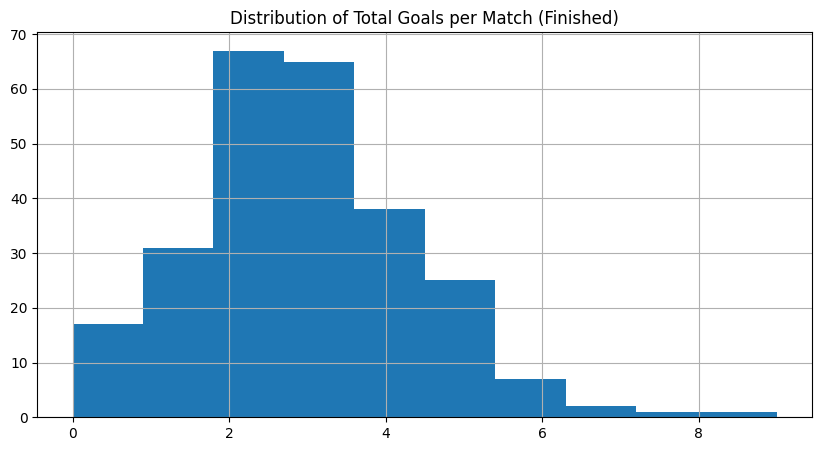

,team_id,team_shortname,team_tla
0,57,Arsenal,ARS
1,58,Aston Villa,AVL
2,1044,Bournemouth,BOU
3,402,Brentford,BRE
4,397,Brighton Hove,BHA
5,328,Burnley,BUR
6,61,Chelsea,CHE
7,354,Crystal Palace,CRY
8,62,Everton,EVE
9,63,Fulham,FUL


In [232]:
finished = matches_df[matches_df["status"] == "FINISHED"].copy()
finished["total_goals"] = finished["full_time_score_home"].fillna(0) + finished["full_time_score_away"].fillna(0)

plt.figure(figsize=(10, 5))
finished["total_goals"].hist(bins=10)
plt.title("Distribution of Total Goals per Match (Finished)")
plt.show()

display(teams_df)


### Loading data into SQL with DuckDB

In [233]:
import duckdb

con = duckdb.connect("epl.duckdb")

con.execute("CREATE OR REPLACE TABLE teams AS SELECT * FROM teams_df")
con.execute("CREATE OR REPLACE TABLE matches AS SELECT * FROM matches_df")

#### Some interesting tables to provide insight

In [234]:
con.execute("""
CREATE OR REPLACE TABLE match_results_per_team AS 
SELECT 
    utc_date AS match_date, 
    match_id AS match_id, 
    home_team AS team, 
    away_team AS opponent, 
    full_time_score_home AS gf, 
    full_time_score_away AS ga, 
    TRUE AS is_home,

CASE 
    WHEN winning_team = 'HOME_TEAM' THEN 'W' 
    WHEN winning_team = 'AWAY_TEAM' THEN 'L' 
    WHEN winning_team = 'DRAW' THEN 'D' 
    ELSE 'TBD' 
END AS result, 

CASE 
    WHEN result = 'W' THEN 3 
    WHEN result = 'L' THEN 0 
    WHEN result = 'D' THEN 1 
    ELSE 0 
END AS points, 
FROM matches 

UNION ALL 

SELECT 
    utc_date AS match_date, 
    match_id AS match_id, 
    away_team AS team, 
    home_team AS opponent, 
    full_time_score_away AS gf, 
    full_time_score_home AS ga, 
    FALSE AS is_home,

CASE 
    WHEN winning_team = 'AWAY_TEAM' THEN 'W' 
    WHEN winning_team = 'HOME_TEAM' THEN 'L' 
    WHEN winning_team = 'DRAW' THEN 'D' 
    ELSE 'TBD' 
END AS result, 

CASE 
    WHEN winning_team = 'AWAY_TEAM' THEN 3 
    WHEN winning_team = 'HOME_TEAM' THEN 0 
    WHEN winning_team = 'DRAW' THEN 1 
    ELSE NULL 
    END AS points,
FROM matches;
"""
)

In [235]:
'''
 This table will contain every match (past and future) in the Premier League this season.
 We will likely reference this table many times for later data organization.
 See table visualized below.
'''

con.query("SELECT * FROM match_results_per_team")

┌──────────────────────────┬──────────┬────────────────────────────┬───────────────────────────┬────────┬────────┬─────────┬─────────┬────────┐
│        match_date        │ match_id │            team            │         opponent          │   gf   │   ga   │ is_home │ result  │ points │
│ timestamp with time zone │  int64   │          varchar           │          varchar          │ double │ double │ boolean │ varchar │ int32  │
├──────────────────────────┼──────────┼────────────────────────────┼───────────────────────────┼────────┼────────┼─────────┼─────────┼────────┤
│ 2025-08-15 12:00:00-07   │   537785 │ Liverpool FC               │ AFC Bournemouth           │    4.0 │    2.0 │ true    │ W       │      3 │
│ 2025-08-16 04:30:00-07   │   537786 │ Aston Villa FC             │ Newcastle United FC       │    0.0 │    0.0 │ true    │ D       │      1 │
│ 2025-08-16 07:00:00-07   │   537787 │ Brighton & Hove Albion FC  │ Fulham FC                 │    1.0 │    1.0 │ true    │ D       │  

In [236]:
con.execute("""
CREATE OR REPLACE TABLE last_5_matches AS
SELECT 
    l5.team,
    l5.form,
    l5.last_5_points,
    l5.num_matches,
    total.season_points
FROM (
    SELECT 
        team,
        STRING_AGG(result, '' ORDER BY match_date ASC) AS form,
        SUM(points) AS last_5_points,
        COUNT(*) AS num_matches
    FROM (
        SELECT 
            team,
            result,
            points,
            match_date,
            ROW_NUMBER() OVER (PARTITION BY team ORDER BY match_date DESC) AS match_recency
        FROM match_results_per_team
        WHERE result != 'TBD'
    ) AS recent_matches
    WHERE match_recency <= 5
    GROUP BY team
) AS l5
JOIN (
    SELECT 
        team,
        SUM(points) AS season_points
    FROM match_results_per_team
    WHERE result != 'TBD'
    GROUP BY team
) AS total ON l5.team = total.team
ORDER BY total.season_points DESC, l5.last_5_points DESC
""")

In [237]:
'''
This table is a traditional soccer bracket, displaying results of the previous 5 matches and total season points thus far.
The idea of "form" (performance in recent matches) will become an important feature in our model.
See table below.
'''

con.query("SELECT * FROM last_5_matches")

┌────────────────────────────┬─────────┬───────────────┬─────────────┬───────────────┐
│            team            │  form   │ last_5_points │ num_matches │ season_points │
│          varchar           │ varchar │    int128     │    int64    │    int128     │
├────────────────────────────┼─────────┼───────────────┼─────────────┼───────────────┤
│ Arsenal FC                 │ DDLWW   │             8 │           5 │            56 │
│ Manchester City FC         │ DLWDW   │             8 │           5 │            50 │
│ Aston Villa FC             │ DLWLD   │             5 │           5 │            47 │
│ Manchester United FC       │ WWWWD   │            13 │           5 │            45 │
│ Chelsea FC                 │ WWWWD   │            13 │           5 │            44 │
│ Brentford FC               │ WLLWW   │             9 │           5 │            39 │
│ Liverpool FC               │ DDLWL   │             5 │           5 │            39 │
│ AFC Bournemouth            │ DWWDW   │   

In [238]:
con.execute("""
CREATE OR REPLACE TABLE attack_defense_strength AS
SELECT
    team,
    SUM(gf) AS total_gf,
    SUM(ga) AS total_ga
FROM match_results_per_team

GROUP BY team
ORDER BY total_gf / total_ga DESC
""")

In [239]:
'''
This table will familiarize us with the number of goals scored contrasted with the number of goals conceded for all Premier League teams.
Sorted by the ratio of goals scored to goals conceded.
See below.
'''

con.query("SELECT * FROM attack_defense_strength")

┌────────────────────────────┬──────────┬──────────┐
│            team            │ total_gf │ total_ga │
│          varchar           │  double  │  double  │
├────────────────────────────┼──────────┼──────────┤
│ Arsenal FC                 │     49.0 │     17.0 │
│ Manchester City FC         │     51.0 │     24.0 │
│ Chelsea FC                 │     47.0 │     30.0 │
│ Aston Villa FC             │     36.0 │     27.0 │
│ Manchester United FC       │     47.0 │     37.0 │
│ Brentford FC               │     39.0 │     34.0 │
│ Liverpool FC               │     40.0 │     35.0 │
│ Brighton & Hove Albion FC  │     34.0 │     33.0 │
│ Newcastle United FC        │     37.0 │     37.0 │
│ Tottenham Hotspur FC       │     36.0 │     37.0 │
│ Everton FC                 │     29.0 │     30.0 │
│ AFC Bournemouth            │     43.0 │     45.0 │
│ Fulham FC                  │     35.0 │     37.0 │
│ Sunderland AFC             │     27.0 │     29.0 │
│ Crystal Palace FC          │     26.0 │     

In [240]:
con.execute("""
CREATE OR REPLACE TABLE home_vs_away_results AS
SELECT
    team,
    SUM(home_gf) AS home_gf,
    SUM(home_ga) AS home_ga, 
    SUM(away_gf) AS away_gf,
    SUM(away_ga) AS away_ga
FROM (
    SELECT
        team,
        SUM(gf) AS home_gf,
        SUM(ga) AS home_ga,
        0 AS away_gf,
        0 AS away_ga
    FROM match_results_home
    GROUP BY team

    UNION ALL

    SELECT
        team,
        0 AS home_gf,
        0 AS home_ga,
        sum(gf) AS away_gf,
        SUM(ga) AS away_ga
    FROM match_results_away 
    GROUP BY team 
    ) combined
    GROUP BY team
    ORDER BY team;
""")

In [241]:
'''
This table shows us the scoring record of all premier league teams during matches at their home stadium and opponents' stadiums.
This difference will also become a strong feature of our predictive model.
See below.
'''

con.query("SELECT * FROM home_vs_away_results")

┌────────────────────────────┬─────────┬─────────┬─────────┬─────────┐
│            team            │ home_gf │ home_ga │ away_gf │ away_ga │
│          varchar           │ double  │ double  │ double  │ double  │
├────────────────────────────┼─────────┼─────────┼─────────┼─────────┤
│ AFC Bournemouth            │    20.0 │    14.0 │    23.0 │    31.0 │
│ Arsenal FC                 │    31.0 │     8.0 │    18.0 │     9.0 │
│ Aston Villa FC             │    18.0 │    10.0 │    18.0 │    17.0 │
│ Brentford FC               │    23.0 │    12.0 │    16.0 │    22.0 │
│ Brighton & Hove Albion FC  │    20.0 │    14.0 │    14.0 │    19.0 │
│ Burnley FC                 │    12.0 │    19.0 │    13.0 │    30.0 │
│ Chelsea FC                 │    22.0 │    15.0 │    25.0 │    15.0 │
│ Crystal Palace FC          │    11.0 │    15.0 │    15.0 │    14.0 │
│ Everton FC                 │    16.0 │    18.0 │    13.0 │    12.0 │
│ Fulham FC                  │    22.0 │    16.0 │    13.0 │    21.0 │
│ Leed

#### Predictably, teams perform better at home stadiums.
##### Visualization below!

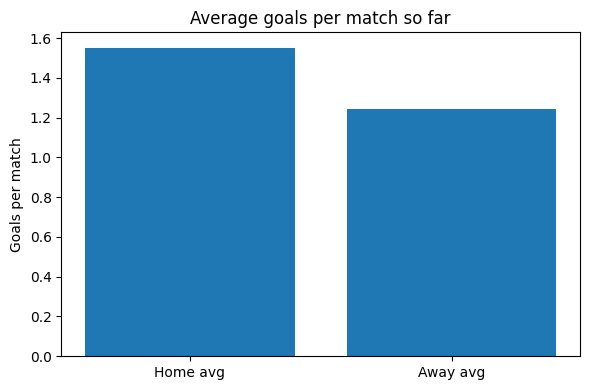

In [242]:
df = con.execute("""
SELECT full_time_score_home AS home_goals, full_time_score_away AS away_goals
FROM matches
WHERE status = 'FINISHED'
  AND home_goals IS NOT NULL
  AND away_goals IS NOT NULL
""").fetchdf()

home_avg = df["home_goals"].mean()
away_avg = df["away_goals"].mean()

import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.bar(["Home avg", "Away avg"], [home_avg, away_avg])
plt.ylabel("Goals per match")
plt.title("Average goals per match so far")
plt.tight_layout()
plt.show()


In [243]:
con.execute("""
CREATE OR REPLACE TABLE team_current_form AS
SELECT
  *,
  AVG(gf) OVER w AS gf_avg_last5,
  AVG(ga) OVER w AS ga_avg_last5,
  AVG(points) OVER w AS pts_avg_last5,
  SUM(points) OVER w AS pts_sum_last5,
  COUNT(*) OVER w AS n_played_last5
FROM match_results_per_team
WHERE result != 'TBD'
WINDOW w AS (
  PARTITION BY team
  ORDER BY match_date, match_id
  ROWS BETWEEN 4 PRECEDING AND CURRENT ROW
);
""")


In [244]:
'''
This table expands on the idea of "form" that I previously mentioned.
By calculating the average goals for/against a team, along with their rolling form, we can calulate how well they are performing when compared to different moments in their season.
This will become a large part of our match_features table.
See below.
'''

con.query("SELECT * FROM team_current_form")

┌──────────────────────────┬──────────┬─────────────────┬────────────────────────────┬────────┬────────┬─────────┬─────────┬────────┬────────────────────┬────────────────────┬───────────────┬───────────────┬────────────────┐
│        match_date        │ match_id │      team       │          opponent          │   gf   │   ga   │ is_home │ result  │ points │    gf_avg_last5    │    ga_avg_last5    │ pts_avg_last5 │ pts_sum_last5 │ n_played_last5 │
│ timestamp with time zone │  int64   │     varchar     │          varchar           │ double │ double │ boolean │ varchar │ int32  │       double       │       double       │    double     │    int128     │     int64      │
├──────────────────────────┼──────────┼─────────────────┼────────────────────────────┼────────┼────────┼─────────┼─────────┼────────┼────────────────────┼────────────────────┼───────────────┼───────────────┼────────────────┤
│ 2025-08-15 12:00:00-07   │   537785 │ AFC Bournemouth │ Liverpool FC               │    2.0 │    4

In [245]:
con.execute("""
CREATE OR REPLACE TABLE match_features AS
WITH
home_side AS (
  SELECT match_id, match_date, team AS home_team, gf AS home_goals, ga AS away_goals, result AS home_result
  FROM match_results_per_team
  WHERE is_home = TRUE AND result != 'TIMED'
),
away_side AS (
  SELECT match_id, match_date, team AS away_team
  FROM match_results_per_team
  WHERE is_home = FALSE AND result != 'TIMED'
),
matches AS (
  SELECT h.match_id, h.match_date, h.home_team, a.away_team, h.home_goals, h.away_goals, h.home_result
  FROM home_side h
  JOIN away_side a USING (match_id)
)
SELECT
  m.*,

  hf.gf_avg_last5 AS home_gf_avg_last5,
  hf.ga_avg_last5 AS home_ga_avg_last5,
  hf.pts_avg_last5 AS home_pts_avg_last5,
  hf.pts_sum_last5 AS home_pts_sum_last5,
  hf.n_played_last5 AS home_n_played_last5,

  af.gf_avg_last5 AS away_gf_avg_last5,
  af.ga_avg_last5 AS away_ga_avg_last5,
  af.pts_avg_last5 AS away_pts_avg_last5,
  af.pts_sum_last5 AS away_pts_sum_last5,
  af.n_played_last5 AS away_n_played_last5

FROM matches m

LEFT JOIN LATERAL (
  SELECT gf_avg_last5, ga_avg_last5, pts_avg_last5, pts_sum_last5, n_played_last5
  FROM team_current_form t
  WHERE t.team = m.home_team
  AND (t.match_date < m.match_date OR (t.match_date = m.match_date AND t.match_id < m.match_id))
ORDER BY t.match_date DESC, t.match_id DESC
LIMIT 1
) hf ON TRUE

LEFT JOIN LATERAL (
  SELECT gf_avg_last5, ga_avg_last5, pts_avg_last5, pts_sum_last5, n_played_last5
  FROM team_current_form t
  WHERE t.team = m.away_team
  AND (t.match_date < m.match_date OR (t.match_date = m.match_date AND t.match_id < m.match_id))
ORDER BY t.match_date DESC, t.match_id DESC
LIMIT 1
) af ON TRUE;
""")


In [246]:
'''
Our most complex table including most if not all of the information we will be using to train our model.
Note that the first 4 games of each teams 25-26 Premier League season will not display average goal differential nor other average calcuations due to a lack of data.
Furthermore, the games that have not yet been played have empty home and away goal attributes, which we will have to clean before doing our training.
See below.
'''

con.execute("SELECT * FROM match_features ORDER BY match_id").fetchdf()


,match_id,match_date,home_team,away_team,home_goals,away_goals,home_result,home_gf_avg_last5,home_ga_avg_last5,home_pts_avg_last5,home_pts_sum_last5,home_n_played_last5,away_gf_avg_last5,away_ga_avg_last5,away_pts_avg_last5,away_pts_sum_last5,away_n_played_last5
0,537785,2025-08-15 12:00:00-07:00,Liverpool FC,AFC Bournemouth,4.0,2.0,W,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,<NA>
1,537786,2025-08-16 04:30:00-07:00,Aston Villa FC,Newcastle United FC,0.0,0.0,D,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,<NA>
2,537787,2025-08-16 07:00:00-07:00,Brighton & Hove Albion FC,Fulham FC,1.0,1.0,D,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,<NA>
3,537788,2025-08-17 06:00:00-07:00,Nottingham Forest FC,Brentford FC,3.0,1.0,W,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,<NA>
4,537789,2025-08-16 07:00:00-07:00,Sunderland AFC,West Ham United FC,3.0,0.0,W,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,538160,2026-05-24 08:00:00-07:00,Liverpool FC,Brentford FC,NaN,NaN,TBD,1.6,1.4,1.0,5.0,5,1.4,1.2,1.8,9.0,5
376,538161,2026-05-24 08:00:00-07:00,Manchester City FC,Aston Villa FC,NaN,NaN,TBD,1.4,1.2,1.6,8.0,5,0.6,0.6,1.0,5.0,5
377,538162,2026-05-24 08:00:00-07:00,Nottingham Forest FC,AFC Bournemouth,NaN,NaN,TBD,1.2,1.0,1.6,8.0,5,1.8,1.0,2.2,11.0,5
378,538163,2026-05-24 08:00:00-07:00,Tottenham Hotspur FC,Everton FC,NaN,NaN,TBD,1.2,2.0,0.4,2.0,5,1.2,1.0,1.6,8.0,5


# Training our Model

##### Splitting our model into test and training datasets, where our training is previously played games and our testing is future games

In [247]:
import numpy as np

training_df = con.execute(
"""
SELECT *
FROM match_features
WHERE home_goals IS NOT NULL AND away_goals IS NOT NULL
""").fetch_df()


upcoming_df = con.execute(
"""
SELECT *
FROM match_features
WHERE home_goals IS NULL OR away_goals IS NULL
""").fetchdf()

training_df.head()

,match_id,match_date,home_team,away_team,home_goals,away_goals,home_result,home_gf_avg_last5,home_ga_avg_last5,home_pts_avg_last5,home_pts_sum_last5,home_n_played_last5,away_gf_avg_last5,away_ga_avg_last5,away_pts_avg_last5,away_pts_sum_last5,away_n_played_last5
0,537804,2025-08-22 12:00:00-07:00,West Ham United FC,Chelsea FC,1.0,5.0,L,0.0,3.0,0.0,0.0,1,0.0,0.0,1.0,1.0,1
1,537802,2025-08-23 04:30:00-07:00,Manchester City FC,Tottenham Hotspur FC,0.0,2.0,L,4.0,0.0,3.0,3.0,1,3.0,0.0,3.0,3.0,1
2,537795,2025-08-23 07:00:00-07:00,AFC Bournemouth,Wolverhampton Wanderers FC,1.0,0.0,W,2.0,4.0,0.0,0.0,1,0.0,4.0,0.0,0.0,1
3,537798,2025-08-23 07:00:00-07:00,Brentford FC,Aston Villa FC,1.0,0.0,W,1.0,3.0,0.0,0.0,1,0.0,0.0,1.0,1.0,1
4,537799,2025-08-23 07:00:00-07:00,Burnley FC,Sunderland AFC,2.0,0.0,W,0.0,3.0,0.0,0.0,1,3.0,0.0,3.0,3.0,1


In [248]:
upcoming_df.head()

,match_id,match_date,home_team,away_team,home_goals,away_goals,home_result,home_gf_avg_last5,home_ga_avg_last5,home_pts_avg_last5,home_pts_sum_last5,home_n_played_last5,away_gf_avg_last5,away_ga_avg_last5,away_pts_avg_last5,away_pts_sum_last5,away_n_played_last5
0,538036,2026-02-11 11:30:00-08:00,Aston Villa FC,Brighton & Hove Albion FC,NaN,NaN,TBD,0.6,0.6,1.0,5.0,5,0.8,1.2,0.6,3.0,5
1,538037,2026-02-11 11:30:00-08:00,Crystal Palace FC,Burnley FC,NaN,NaN,TBD,0.8,1.2,1.0,5.0,5,1.0,2.0,0.6,3.0,5
2,538041,2026-02-11 11:30:00-08:00,Manchester City FC,Fulham FC,NaN,NaN,TBD,1.4,1.2,1.6,8.0,5,1.4,1.6,1.2,6.0,5
3,538042,2026-02-11 11:30:00-08:00,Nottingham Forest FC,Wolverhampton Wanderers FC,NaN,NaN,TBD,1.2,1.0,1.6,8.0,5,0.4,1.6,0.4,2.0,5
4,538035,2026-02-11 12:15:00-08:00,Sunderland AFC,Liverpool FC,NaN,NaN,TBD,1.2,2.0,1.2,6.0,5,1.6,1.4,1.0,5.0,5


#### Fitting our model!
<p> I find that Poisson Regression will likely be the most appropriate for our use case given we are predicting how many times something is going to happen.
Furthermore, the goals naturally have a right skewed distribution due to the lack of negative scores, which Poisson naturally models.
Not to mention, historically Poisson models have been the go-to choice for soccer predictions. </p>

In [249]:
from sklearn.linear_model import PoissonRegressor

train = training_df.copy()         # Making copies of our train and test dataframes
upcoming = upcoming_df.copy()

form_cols = [
    "home_gf_avg_last5", "home_ga_avg_last5", "home_pts_avg_last5", "home_pts_sum_last5", "home_n_played_last5",        # Columns of our desired form-centric features
    "away_gf_avg_last5", "away_ga_avg_last5", "away_pts_avg_last5", "away_pts_sum_last5", "away_n_played_last5",
]

for c in form_cols:
    if c in train.columns:
        train[c] = train[c].fillna(0)       # Cleaning up the empty values in our data to avoid error (Particularly important in our test dataset)
    if c in upcoming.columns:
        upcoming[c] = upcoming[c].fillna(0)

X_train_cat = pd.get_dummies(train[["home_team","away_team"]], drop_first=False) # Our PoissonRegressor model needs numbers, not text. So we will use numeric indication for each team.
X_train_num = train[[c for c in form_cols if c in train.columns]]                # For example: home_team_Arsenal = 1, etc.

X_train = pd.concat([X_train_cat, X_train_num], axis=1)     # Combining our categorical (team one-hots) and numerical (form metrics) features into one matrix for model expectations.
X_cols = X_train.columns

y_home = train["home_goals"].astype(int).values     # Casting to int for Poisson Regression count data.
y_away = train["away_goals"].astype(int).values

X_up_cat = pd.get_dummies(upcoming[["home_team","away_team"]], drop_first=False)
X_up_num = upcoming[[c for c in form_cols if c in upcoming.columns]]

X_up = pd.concat([X_up_cat, X_up_num], axis=1).reindex(columns=X_cols, fill_value=0)



home_model = PoissonRegressor(alpha=0.1, max_iter=2000).fit(X_train, y_home)        # Learns a mapping from features to expected home goals
away_model = PoissonRegressor(alpha=0.1, max_iter=2000).fit(X_train, y_away)        # Same as above, but for away goals. Alpha adds some regularization to the model to avoid over-fitting

print("fit complete")


fit complete


In [250]:
upcoming["pred_home_xg"] = home_model.predict(X_up)
upcoming["pred_away_xg"] = away_model.predict(X_up)         # Making our predictions for home and away goals based on current performance and previous home/away goals.

upcoming[["match_date","home_team","away_team","pred_home_xg","pred_away_xg"]].sort_values("match_date").head(15)

,match_date,home_team,away_team,pred_home_xg,pred_away_xg
0,2026-02-11 11:30:00-08:00,Aston Villa FC,Brighton & Hove Albion FC,1.671865,1.276966
1,2026-02-11 11:30:00-08:00,Crystal Palace FC,Burnley FC,1.683516,1.235911
2,2026-02-11 11:30:00-08:00,Manchester City FC,Fulham FC,2.073735,0.990158
3,2026-02-11 11:30:00-08:00,Nottingham Forest FC,Wolverhampton Wanderers FC,1.653239,1.023789
4,2026-02-11 12:15:00-08:00,Sunderland AFC,Liverpool FC,1.670635,1.161392
5,2026-02-12 12:00:00-08:00,Brentford FC,Arsenal FC,1.460568,1.216709
6,2026-02-18 12:00:00-08:00,Wolverhampton Wanderers FC,Arsenal FC,0.985116,2.068919
7,2026-02-21 07:00:00-08:00,Aston Villa FC,Leeds United FC,1.716586,1.309469
8,2026-02-21 07:00:00-08:00,Brentford FC,Brighton & Hove Albion FC,1.955213,1.058329
9,2026-02-21 07:00:00-08:00,Chelsea FC,Burnley FC,2.322972,0.839580


#### Bonus
##### Complicated math to output the probability of each team winning, losing, or drawing.

In [251]:
import math
import numpy as np

def poisson_pmf(k, lam):
    return (lam**k) * math.exp(-lam) / math.factorial(k)

def wdl_probs(lh, la, max_goals=6):
    p_home = p_draw = p_away = 0.0
    for i in range(max_goals + 1):
        pi = poisson_pmf(i, lh)
        for j in range(max_goals + 1):
            p = pi * poisson_pmf(j, la)
            if i > j: p_home += p
            elif i == j: p_draw += p
            else: p_away += p
    return p_home, p_draw, p_away

probs = [wdl_probs(h, a) for h, a in zip(upcoming["pred_home_xg"], upcoming["pred_away_xg"])]
upcoming[["p_home","p_draw","p_away"]] = pd.DataFrame(probs, index=upcoming.index)

upcoming["pick"] = upcoming[["p_home","p_draw","p_away"]].idxmax(axis=1).map({
    "p_home":"HOME", "p_draw":"DRAW", "p_away":"AWAY"
})

upcoming[["match_date","home_team","away_team","pred_home_xg","pred_away_xg","p_home","p_draw","p_away","pick"]].sort_values("match_date").head(5)


,match_date,home_team,away_team,pred_home_xg,pred_away_xg,p_home,p_draw,p_away,pick
0,2026-02-11 11:30:00-08:00,Aston Villa FC,Brighton & Hove Albion FC,1.671865,1.276966,0.465167,0.240206,0.292556,HOME
1,2026-02-11 11:30:00-08:00,Crystal Palace FC,Burnley FC,1.683516,1.235911,0.477042,0.240067,0.280817,HOME
2,2026-02-11 11:30:00-08:00,Manchester City FC,Fulham FC,2.073735,0.990158,0.617904,0.204635,0.171896,HOME
3,2026-02-11 11:30:00-08:00,Nottingham Forest FC,Wolverhampton Wanderers FC,1.653239,1.023789,0.519242,0.244723,0.234334,HOME
4,2026-02-11 12:15:00-08:00,Sunderland AFC,Liverpool FC,1.670635,1.161392,0.490950,0.242107,0.265035,HOME


# Conclusions
<p> I pulled match data through an API and stored it in a local DuckDB database. I then engineered team “recent form” features using rolling last-5 windows (e.g., goals for/against and points) and combined them with team identity features (one-hot encoded home/away teams). I then trained two PoissonRegressor models: one to predict expected home goals and one for expected away goals. Since goals are non-negative, count data and Poisson regression naturally outputs positive scoring rates. Using these expected goals, we generated match predictions (including predicted goals from both teams), and W/D/L probabilities for upcoming Premier League matches. 

Many key findings were consistent with common league/sports patterns: Home teams generally score more than away teams, and team identity(general strength) typically gives us a good baseline for these predictions. We also added last-5 game features to adjust a team's baseline up or down depending on their recent performance (the snowball effect seems to be quite real in sports), although not really applying to early season metrics provided that we did not have sufficient data.

I'd like to emphasize that there are theoretically numerous ways to improve this model (some are prevalent in the most accurate score predicting models today), but to list a few: adding more data on previous seasons, more predictors like injury, suspensions, or betting odds, or even head-to-head matchup records to analyze strategic counterplay between clubs.
</p>